# Single-Cell Analysis

v0.1 - 22/03/25

The purpose of this notebook is to give a basic example of how to perform single-cell analysis of SpaceM data, more precisely the following steps:  

- Loading multiple SpaceM datasets
- QC & Preprocessing
- Dimensionality reduction (i.e. creating a UMAP)
- Clustering
- Differential analysis

These steps are demonstrated using a SpaceM perturbation dataset generously donated by Luísa. 
If you want to run this notebook yourself, you can download the dataset [here](https://oc.embl.de/index.php/s/1eMkXRIS8HE2qoY).  
The dataset contains the metabolomes of cells subjected to one of four different treatments in order to induce metabolic changes, with five replicates for each treatment.

You are also invited to also use this notebook as a basis for your own analysis - keep in mind however that each analysis often needs to be custom-tailored to your data. Feel free to reach out to Alex if you need help!

Before you read this notebook, also consider checking out [this primer](https://scanpy.readthedocs.io/en/stable/usage-principles.html) on the core usage principles of Scanpy, the main Python package we're going to use for single-cell analysis.

### Setup


<div class="alert alert-info">

**Note:** Make sure to install both [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [Outer SpaceM](https://mattausc.embl-community.io/outer-spacem/installation.html) before running this notebook!

</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import outer_spacem as osm
import os

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

sns.set(
    rc={
        "figure.figsize":(5, 5),
        "legend.frameon": False
    },
    style="ticks",
    context="talk"
)

### Setup of paths and names

In [2]:
well = "Drug_W8"
analysis_name = "v1"

### Loading the data

In [3]:
main_dir = os.path.join("/Users/alberto-mac/EMBL_ATeam/projects/gastrosome",
                       well, "reprocessing")

adata = sc.read(os.path.join(main_dir, "single_cell_analysis/spatiomolecular_adata.h5ad")) 

# intracell_ions = pd.read_csv("/Users/alberto-mac/EMBL_ATeam/projects/gastrosome/molecules_databases/reannotated/AB_Gastrosome_DrugW8_intra_ions_v2.tsv",
                             # sep="\t", index_col=0)

proj_dir = os.path.join(main_dir, "analysis", analysis_name)

#### Mark gastrosomes

In [4]:
cond_col = "cell_type"

adata.obs[cond_col] = np.where(adata.obs["max_intensity-Annotations"] > 0., "Gastrosomes", "Other cells")
adata.obs = adata.obs.astype({cond_col: "category"})


In [5]:
nb_marked_cells = (adata.obs[cond_col] == "Gastrosomes").sum()
total_nb_cells = adata.obs[cond_col].shape[0]
print("Gastrosomes: {}/{} cells".format(nb_marked_cells, total_nb_cells))

Gastrosomes: 172/9480 cells


### Preprocessing

#### Quality control

Let's first perform some quality control.
For starters, let's check the size of our dataset:

In [6]:
adata.shape

(9480, 866)

Our dataset consists of roughly 17000 cells described by 547 unique ions.  
Let's get some more detailed QC metrics:

In [7]:
cell_qc, ion_qc = sc.pp.calculate_qc_metrics(adata)

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


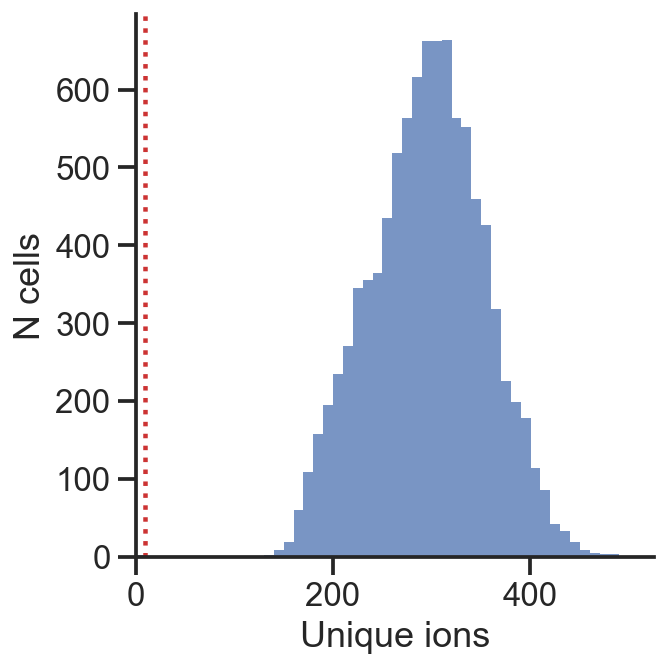

In [8]:
sns.displot(data=cell_qc, x="n_genes_by_counts", bins=50, linewidth=0)
plt.xlabel('Unique ions')
plt.ylabel('N cells')
plt.xlim(left=0)
plt.axvline(x=10, linestyle=":", c="#CC3333")
plt.show()

Seems like most of our cells have 100-200 unique ions, and there is close to 0 cells that only have very few annotations.

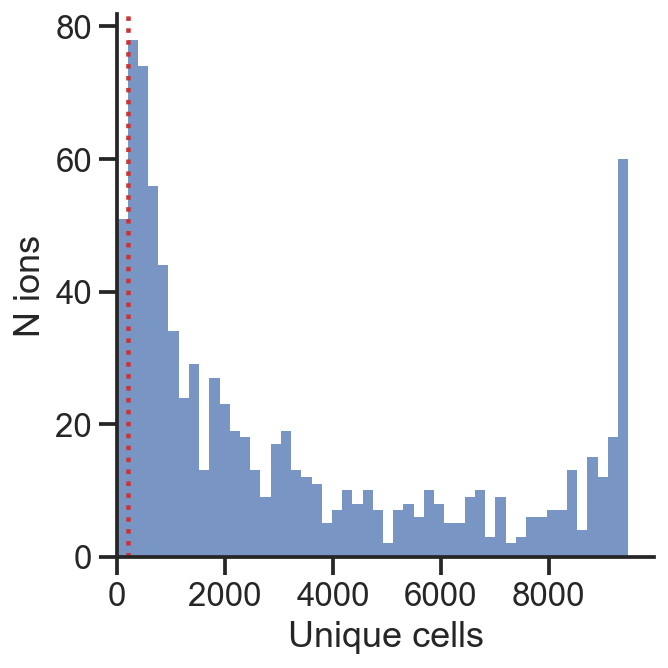

In [9]:
sns.displot(data=ion_qc, x="n_cells_by_counts", bins=50, linewidth=0)
plt.xlabel('Unique cells')
plt.ylabel('N ions')
plt.xlim(left=0)
plt.axvline(x=200, linestyle=":", c="#CC3333")
plt.show()

There seems to be plenty of ions however that only occur in a low number of cells.

#### Filtering cells and ions
Cells with only few annotations may not have been sampled by the MALDI laser sufficiently, and should therefore be removed.  
Ions that are only present in a few cells will contain only little biological information, and removing them reduces dataset complexity.
  
Keep in mind however that the threshold for both filtering steps should be adapted to your own analysis.

In [10]:
adata.raw = adata # keep raw values for diff. analysis

In [11]:
print("Cells before filtering:", adata.shape[0])

sc.pp.filter_cells(adata, min_genes=10)

print("Cells after filtering:", adata.shape[0])

Cells before filtering: 9480
Cells after filtering: 9478


In [12]:
print("Ions before filtering:", adata.shape[1])

sc.pp.filter_genes(adata, min_cells=200)

print("Ions after filtering:", adata.shape[1])

Ions before filtering: 866
Ions after filtering: 812


#### Scaling
Other single-cell omics may require you to scale intensities to achieve more normally distributed counts. For SpaceM data this is not recommended however:  

- Log (or log1p) scaling is commonly used in sequencing-based single-cell analyses to reduce data skewness, but has shown to actually drown out biological information in SpaceM data.
- Z scoring (i.e. centering to 0 and scaling to as standard deviation of 1) has no consensus even in other single-cell omics, from experience it can severely distort SpaceM data.

#### Normalization

Technical aspects of MS imaging for SpaceM cause significant variance in how much biological material is sampled, similarly to varying sequencing depth in scRNA-seq. 
As this sampling variance can severely distort downstream analysis, we're going to apply some normalization to mitigate for it.

The simplest way to do this is by scaling a cell's ion counts using a size factor porportional to the total ion count (TIC) of the cells - commonly referred to as TIC normalization:

In [13]:
# sc.pp.normalize_total(adata)
sc.pp.normalize_total(adata, target_sum=1., key_added='tic')

### Dimensionality reduction

We'll perform some dimensionality reduction in order to get a visual overview of our data.
In short, we'll create a **U**niform **M**anifold **A**pproximation and **P**rojection (UMAP) representation of our data that will give us a overview of the 
biological (i.e. wanted) and technical (i.e. unwanted) variance within the sample e.g. similarity of cell types, conditions or replicates.

You can read more about dimensionality reduction in single-cell analysis [here](https://chanzuckerberg.github.io/scRNA-python-workshop/analysis/03-dimensionality-reduction.html).

In [14]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obs[["UMAP1", "UMAP2"]] = adata.obsm["X_umap"] # transfer to .obs

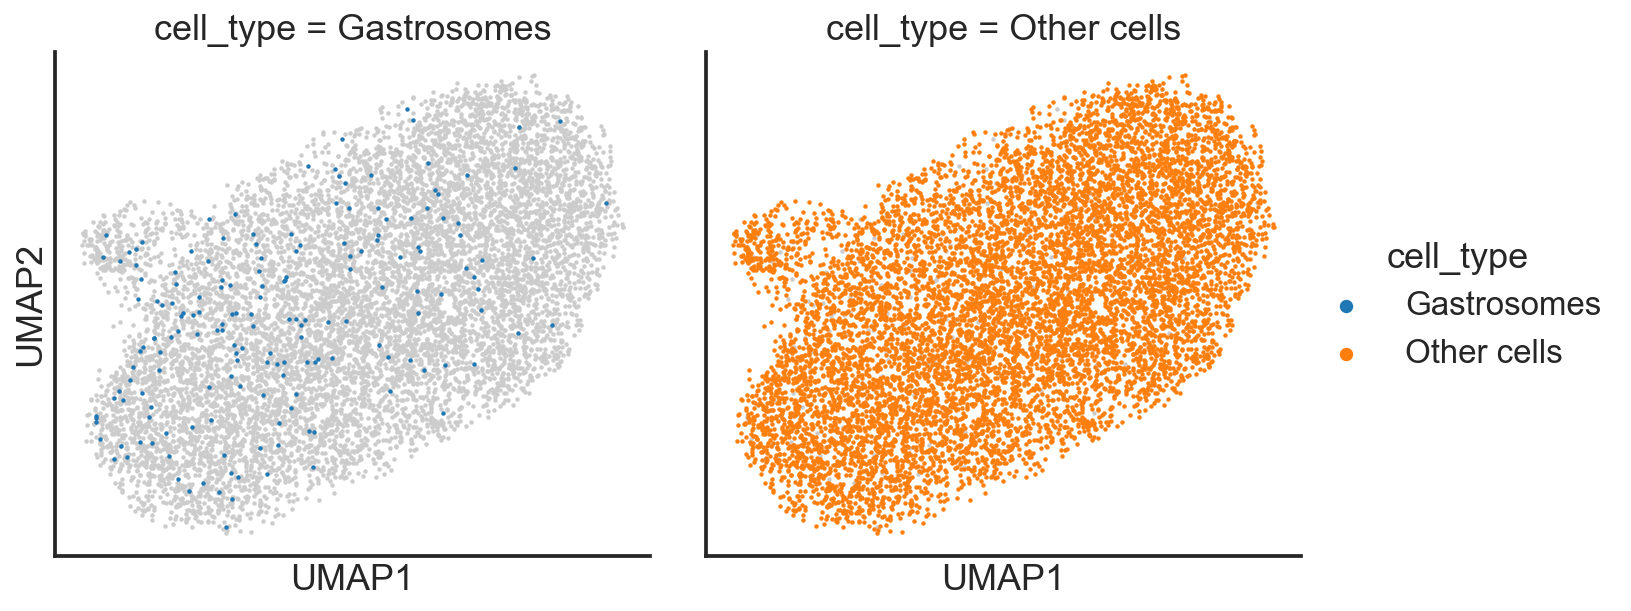

In [15]:
f = osm.pl.highlight_scatterplot(
    data = adata.obs,
    x = "UMAP1",
    y = "UMAP2",
    hue = cond_col,
    col = cond_col,
    palette = "tab10",
    height = 5,
    scatter_kwargs = dict(s=5)
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
plt.show()

Excellent! Seems like different treatments seem to be a major driver of variance in our UMAP!  
Let's take a deeper look however and also check how much variance we have between our replicates.

### Differential Analysis

After identifying groups of cells we might want to know what makes these groups unique, for which we are going to perform differential analysis.

<div class="alert alert-warning"> 

**A fair warning:** there are no data-backed best practices for differential analysis of SpaceM data yet. The steps currently shown here therefore use the most simplistic methods, which may not be universally applicable.
A future update to this notebook will aim to change that and provide more robust methods.

</div>

To identify which ions are differentially abundant between between groups of cells, we will use a series of 1-vs-rest wilcoxon rank-sum tests for each ion:

In [16]:
sc.tl.rank_genes_groups(adata, groupby=cond_col, method="wilcoxon", use_raw=True)

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overf

In [17]:
from singlecelltools.nonzero_wilcoxon import nonzero_wilcoxon
nonzero_wilcoxon(adata, 
    groupby=cond_col,
    use_raw=False, 
    key_added="zero_rank_genes_groups")

Let's check out which ions are most associated with each of our four groups:

We can also visualize the abundance of these ions on our UMAP:

Furthermore, we can check the distribution of p-values and logfoldchanges in a volcano plot:

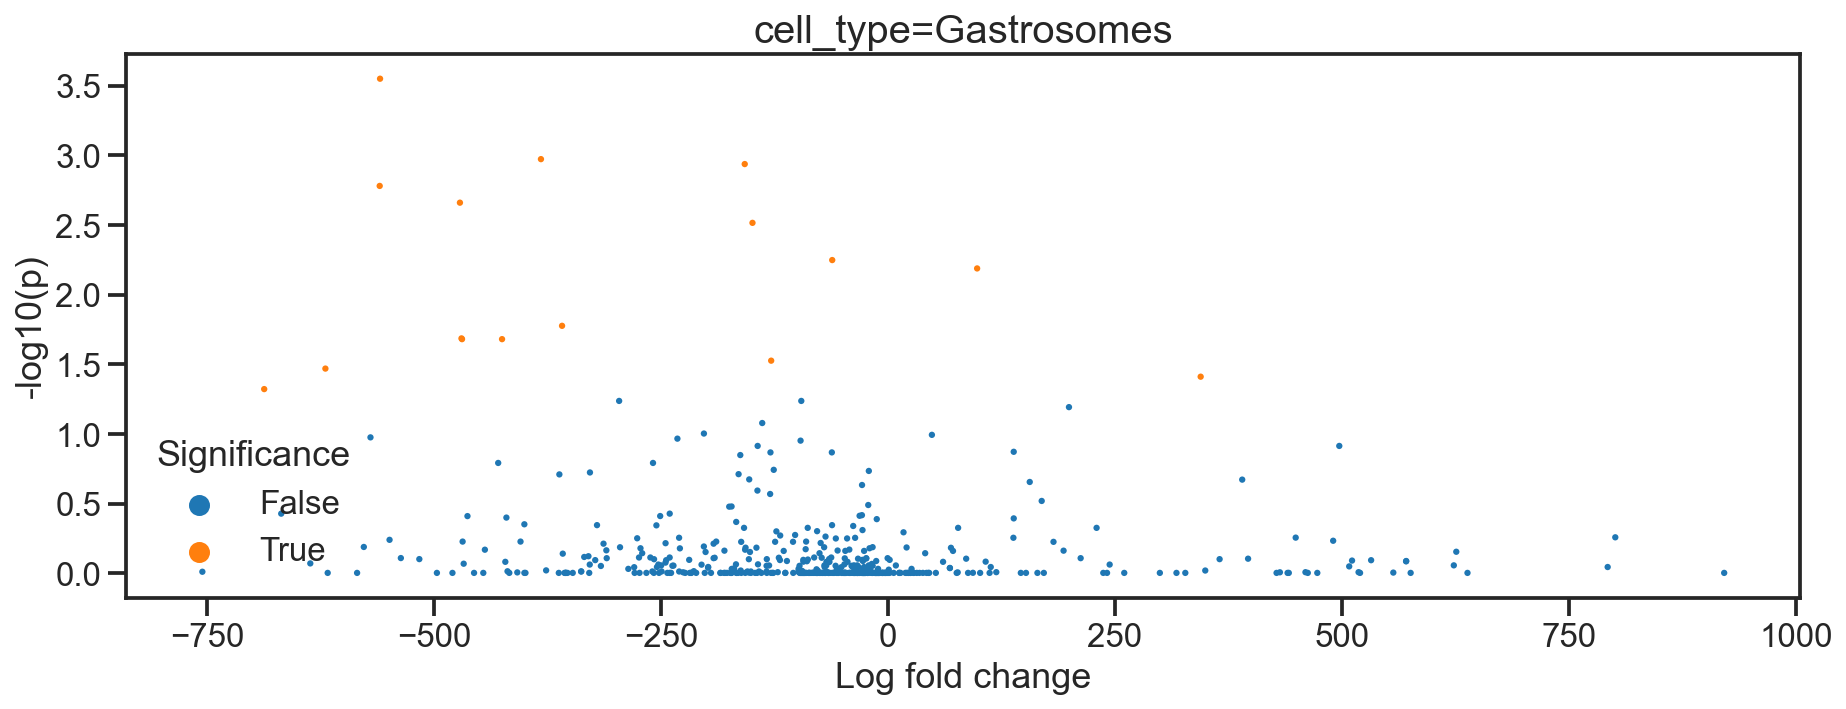

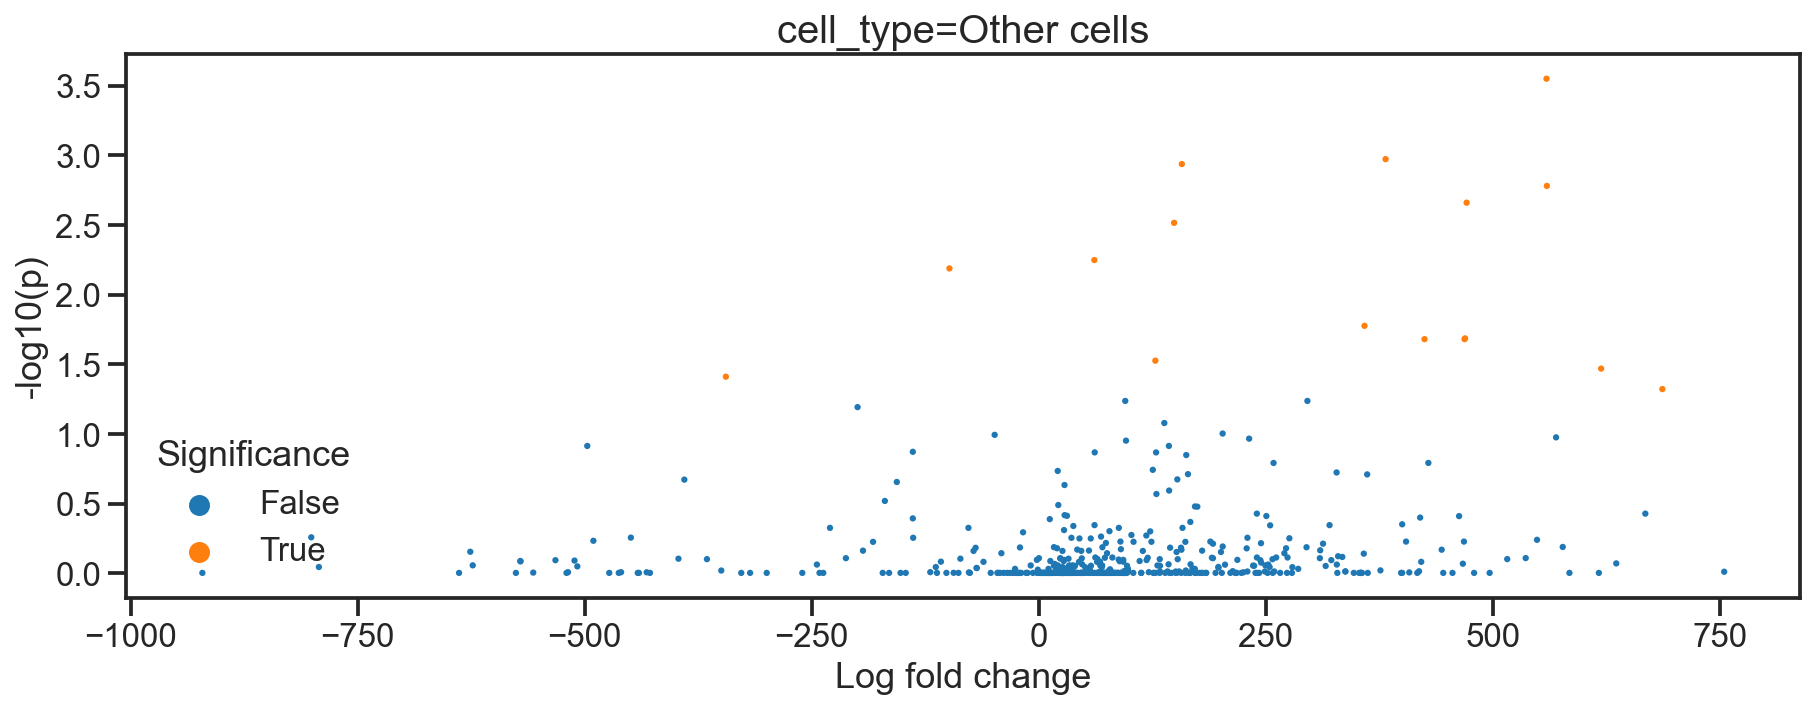

In [18]:
groupname = adata.uns["rank_genes_groups"]["params"]["groupby"] # = "leiden"


pval_thres = 0.05 # upper threshold for p-values
fc_thres = 2 # lower threshold for fold changes

for group in adata.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df["significance"] = (df["pvals_adj"] < pval_thres) & (df["logfoldchanges"].abs() > np.log2(fc_thres))
    df["pvals_adj_nlog10"] = -np.log10(df["pvals_adj"] + np.finfo("f8").eps)
    
    plt.figure(figsize=[15, 5])
    sns.scatterplot(
        data = df,
        x = "logfoldchanges",
        y = "pvals_adj_nlog10",
        s = 10,
        linewidth = 0,
        hue = "significance",
        palette = "tab10"
    )
    plt.xlabel("Log fold change")
    plt.ylabel("-log10(p)")
    plt.legend(loc="lower left", title="Significance")
    plt.title(f"{groupname}={group}", fontsize=20)
    plt.show()

We can see that most ions have either very high or low log fold changes, as well as very low p-values, and it is currently not clearly known what causes these extreme values.  

Nonetheless, we can now export these markers to use them in other analyses:

In [25]:
output_dir = "C:/Users/ama/data/220325_Luisa_ScSeahorse"

for group in adata.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df = df[
        (df["pvals"] < pval_thres) & 
        (df["logfoldchanges"].abs() > np.log2(fc_thres))
    ]

    df_path = f"{output_dir}/{groupname}_{group}_markers.tsv"
    print(df_path)
    df.to_csv(df_path, index=False, sep='\t')

C:/Users/ama/data/220325_Luisa_ScSeahorse/leiden_0_markers.tsv
C:/Users/ama/data/220325_Luisa_ScSeahorse/leiden_1_markers.tsv
C:/Users/ama/data/220325_Luisa_ScSeahorse/leiden_2_markers.tsv
C:/Users/ama/data/220325_Luisa_ScSeahorse/leiden_3_markers.tsv
